# Import dependiencies

In [1]:
import os
import numpy as np
import pandas as pd
import re
import joblib
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from functools import wraps
from itertools import chain
from typing import Callable, List
import seaborn as sns
import matplotlib.pyplot as plt

# Define global variables and constants

In [5]:
DATABASE_PATH = r'..\resources\database'
MODELS_PATH =  r'..\models'
COLUMNS = ['Text', 'Label']
SAVE_MODEL = True

# Load the dataset

In [6]:
emails_xlsx = os.path.join(DATABASE_PATH, 'emails-database.xlsx')

In [7]:
emails_df = pd.read_excel(emails_xlsx)

In [9]:
emails_df.dropna(how='any', subset=['Is Phishy'], inplace=True)

# Preprocess feature matrix

In [10]:
X = emails_df.loc[:, [
    'Content-Length', 
    'X-Virus-Scanned', 
    'X-Priority', 
    'Encoding',
    'Attachments', 
    'URLs', 
    'IPs', 
    'Images', 
    'Is HTML', 
    'Is JavaScript',
    'Is CSS',
    'Raw Message'
]]
y = emails_df['Is Phishy'].astype(int)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6558 entries, 0 to 6557
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Content-Length   710 non-null    float64
 1   X-Virus-Scanned  104 non-null    object 
 2   X-Priority       1741 non-null   object 
 3   Encoding         1068 non-null   object 
 4   Attachments      6558 non-null   int64  
 5   URLs             6558 non-null   int64  
 6   IPs              6558 non-null   int64  
 7   Images           6558 non-null   int64  
 8   Is HTML          6558 non-null   bool   
 9   Is JavaScript    6558 non-null   bool   
 10  Is CSS           6558 non-null   bool   
 11  Raw Message      6516 non-null   object 
dtypes: bool(3), float64(1), int64(4), object(4)
memory usage: 480.4+ KB


* Content-Length is an attribute of an email object and very few emails contain the calculated content-length field. The value includes not only the length of the email body, but also subject(s), recipient(s), message ID(s) etc. A suggested alternative could be to create a new feature 'Message Length' that will calculate the length of encoded [?] message content.
* X-Virus-Scanned contains the infrmation about the anti-virus scanning software. Only a few emails were scanned, therefore the vast majority of the samples has missing data. It might make a sense to impute missing values.
* X-Priority has 75% of the missing entries, however it can be potentially beneficial to impute the missing values. It might make a sense to impute missing values.

In [12]:
def transformer_wrapper(func: Callable) -> FunctionTransformer:
    @wraps(func)
    def wrapper(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        return df.applymap(func, *args, **kwargs)
    return FunctionTransformer(wrapper)

In [13]:
@transformer_wrapper
def enumerate_virus_scanned(virus_scanned: str) -> int:
    return 1 if not pd.isnull(virus_scanned) else 0

In [14]:
@transformer_wrapper
def enumerate_priority(priority: str) -> int:
    try:
        return int(re.search(r'\d+', priority).group(0))
    except (AttributeError, TypeError):
        return 0

In [15]:
@transformer_wrapper
def enumerate_encoding(encoding: str) -> int:
    content_transfer_encoding = {
        "na":  0,
        "base64": 1,
        "quoted-printable": 2,
        "8bit": 3,
        "7bit": 4,
        "binary": 5
    }
    try:
        return content_transfer_encoding[encoding.lower()]
    except (AttributeError, KeyError):
        return 0

In [16]:
@transformer_wrapper
def enumerate_bool(boolean: bool) -> int:
    return int(boolean)

In [17]:
def get_message_length(text: str) -> int:
    return len(str(text))

In [18]:
class AttributeAdderError(Exception):
    """
    Description:
        Exception raised when the number of input columns passed to the Transformer object differs from the number of attributes to add specified. 

    Example:
        ColumnTransformer([(name, AttributeAdder(attributes), columns)]) 
            - columns have shape (a,)
            - attributes have shape (b,)
        Exception is raised when a != b

    Parameters:
        message [str] - explanation of the error
    """

    def __init__(self, message: str = "Dimensions of input columns and attributes to add cannot differ from one another."):
        self.message = message
        super().__init__(self.message)

In [19]:
class AttributeAdder(BaseEstimator, TransformerMixin): 
    
    """
    Description:
        Custom Transformer that applies a function on the input columns passed to the transformer and adds transformed data as new features to the output matrix.

    Parameters:
        - attribs_in: List[str] = list of processed input features.
        - attribs_out: List[str] = list of features added to the output matrix.
        - func: Callable = is a function applied to transform input features.
    
    Usage:
        Transformation step in the pipeline.
    
    Example:
        Let's assume the input feature matrix consists of two columns: ['Net Salary', 'Gross Salary']
        We want to calculate mean salaries and add these values as new attributes: ['Avg Net Salary', 'Avg Gross Salary']
        The pipeline should be initialized as:
            
            sklearn.pipe.Pipeline(steps=[
                ...,
                ('avg_salaries', AttributeAdder(attribs_in=['Avg Net Salary', 'Avg Gross Salary'], attribs_out=['Net Salary', 'Gross Salary'], func=np.mean)),
                ...
            ])

        Remember that the number of columns in the transformed input (attribs_in) must be equal to the number of attributes added (attribs_out). Otherwise, AttributeAdderError is raised.
    """

    def __init__(self, attribs_in: List[str], attribs_out: List[str], func: Callable):
        if len(attribs_in) != len(attribs_out):
            raise AttributeAdderError

        super(AttributeAdder, self).__init__()
        self.attribs_in = attribs_in
        self.attribs_out = attribs_out
        self.func = func
    
    def fit(self, X , y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_ = X[self.attribs_in].applymap(self.func)
        return pd.DataFrame(
            data=np.c_[X, X_],
            columns=[*X.columns, *self.attribs_out]
        )

In [20]:
class AttributeDropout(BaseEstimator, TransformerMixin): 
    
    """
    Description:
        Custom Transformer that removes selected attributes from the feature matrix.

    Parameters:
        - exclude: List[str] = list of features to remove.
    
    Usage:
        Transformation step in the pipeline.
    """

    def __init__(self, exclude: List[str]):
        super(AttributeDropout, self).__init__()
        self.exclude = exclude
    
    def fit(self, X , y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.drop(columns=self.exclude)

In [21]:
class NamedTransformer(ColumnTransformer):  
    """
    Description:
        This is just a ColumnTransformer subclass, additionally supporting a keyed-access to heterogenous, multi-dimensional transformed data.
        Instead of a sparse-matrix, transformed data is returned as tabular pd.DataFrame structure.
        Output having labeled axes is beneficial if access to specific columns is necessary in subsequent transformers as data is propagated forward through a pipeline. 
        Manipulating with sparse matrices negatively impacts the computational time and memory usage as opposed to array-like objects.
    """
    @property
    def features_in(self):
        return list(chain(*[cols for _,_,cols in self.transformers]))

    def fit(self, X, y = None):
        return super().fit(X, y)

    def transform(self, X: pd.DataFrame, y = None) -> pd.DataFrame:
        return self.to_frame(super().transform(X))

    def fit_transform(self, X: pd.DataFrame, y = None) -> pd.DataFrame:
        return self.to_frame(super().fit_transform(X))
    
    def to_frame(self, data) -> pd.DataFrame:
        return pd.DataFrame(data, columns=self.features_in)

In [22]:
def custom_pipeline(exclude: list = [], features_out: bool = False) -> Pipeline:

    # Add 'Message Length' attribute based on the 'Raw Message' column
    attrib_adder = AttributeAdder(attribs_in=['Raw Message'], attribs_out=['Message Length'], func=get_message_length)
    
    # Transform selected columns
    preprocessor = NamedTransformer(transformers=[
        ('virus_scanned', enumerate_virus_scanned, ['X-Virus-Scanned']),
        ('priority', enumerate_priority, ['X-Priority']),
        ('encoding', enumerate_encoding, ['Encoding']),
        ('flags', enumerate_bool, ['Is HTML', 'Is JavaScript', 'Is CSS']),
        ('select', 'passthrough', ['Attachments', 'URLs', 'IPs', 'Images', 'Message Length'])
    ])

    # Drop selected columns
    attrib_dropout = AttributeDropout(exclude)

    # Define pipeline
    pipe = Pipeline(steps=[
        ('attrib_adder', attrib_adder),
        ('preprocessor', preprocessor),
        ('attrib_dropout', attrib_dropout),
        ('scaler', MinMaxScaler())
    ])

    # Get features out
    if features_out:
        features = [col for col in preprocessor.features_in if col not in exclude]
        
        # Return pipeline and features
        return pipe, features
    
    # Return pipeline
    return pipe

In [23]:
pipe, features = custom_pipeline(features_out=True)

In [24]:
X_processed = pd.DataFrame(
    data=pipe.fit_transform(X),
    columns=features
)

# Find most predictive features

In [25]:
cm = pd.concat([X_processed, y], axis=1).corr()

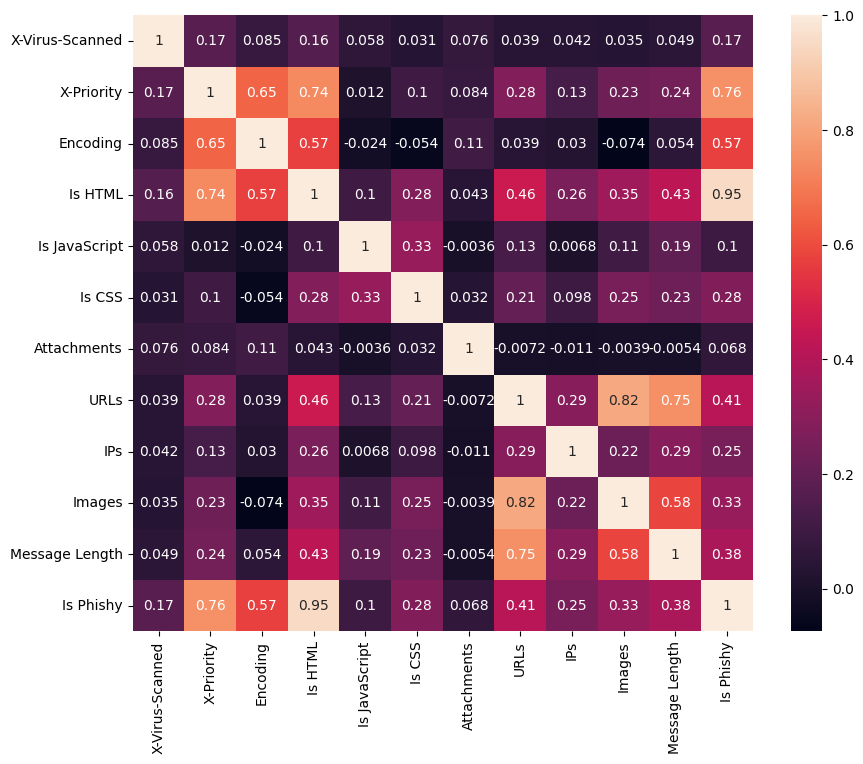

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True)
plt.show()

In [27]:
cm['Is Phishy'].sort_values(key=lambda x: x.abs(), ascending=False)[1:]

Is HTML            0.950115
X-Priority         0.755580
Encoding           0.572610
URLs               0.413790
Message Length     0.382413
Images             0.331515
Is CSS             0.276208
IPs                0.254675
X-Virus-Scanned    0.173941
Is JavaScript      0.100371
Attachments        0.067765
Name: Is Phishy, dtype: float64

In [28]:
FEATURES = cm[cm['Is Phishy'].abs() > 0.1]['Is Phishy'].index[:-1].tolist()
FEATURES

['X-Virus-Scanned',
 'X-Priority',
 'Encoding',
 'Is HTML',
 'Is JavaScript',
 'Is CSS',
 'URLs',
 'IPs',
 'Images',
 'Message Length']

In [44]:
NON_CORRELATED_FEATURES = cm[cm['Is Phishy'].abs() < 0.25]['Is Phishy'].index.tolist()
NON_CORRELATED_FEATURES

['X-Virus-Scanned', 'Is JavaScript', 'Attachments']

# Perform stratified shuffle split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=35)

In [46]:
pipe = custom_pipeline(exclude=NON_CORRELATED_FEATURES)
X_train_norm = pipe.fit_transform(X_train)
X_test_norm = pipe.transform(X_test)

# K-Nearest Neighbor

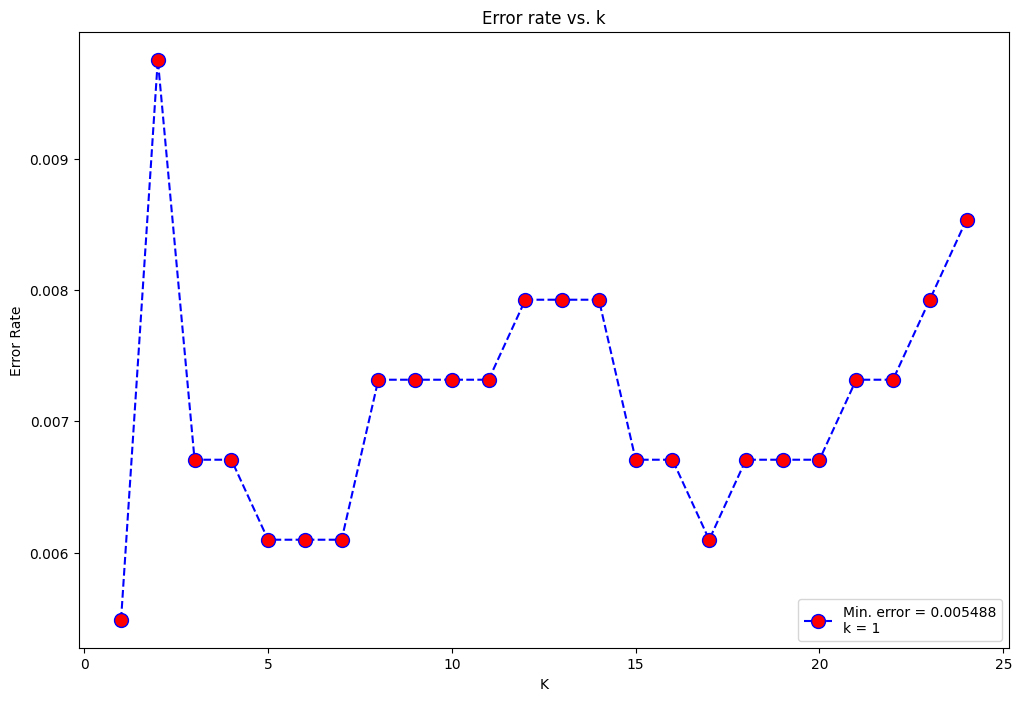

In [48]:
error_rates = pd.Series(dtype=np.float32)
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_norm, y_train)
    y_pred = knn.predict(X_test_norm)
    error = np.mean(y_pred != y_test)
    error_rates.loc[i] = error

plt.figure(figsize=(12, 8))
plt.plot(
    error_rates, 
    color='blue', 
    linestyle='dashed', 
    marker='o',
    markerfacecolor='red', 
    markersize=10,
    label='Min. error = {:.6f}\nk = {}'.format(error_rates.min(), error_rates.idxmin())
)
plt.title('Error rate vs. k')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.legend(loc='lower right')
plt.show()

In [49]:
param_grid={
    'n_neighbors': np.arange(5, 16), 
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(KNeighborsClassifier(), param_grid)

In [50]:
gs.fit(X_train_norm, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'weights': ['uniform', 'distance']})

In [51]:
gs.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

In [52]:
gs.best_estimator_.score(X_test_norm, y_test)

0.9957317073170732

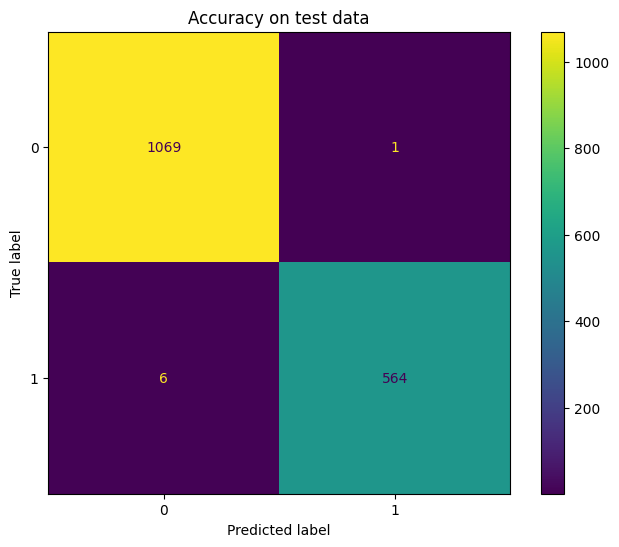

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test_norm, y_test, ax=ax)
plt.title('Accuracy on test data')
plt.show()

# Export trained model

In [55]:
if SAVE_MODEL:
    out_path = os.path.join(MODELS_PATH, 'KNN', 'knn_classifier.joblib')
    joblib.dump(gs.best_estimator_, out_path)
    print(f'[!] Model saved as {os.path.abspath(out_path)}')

[!] Model saved as d:\PyCharm Professional\Projects\MachineLearningPhishing\models\KNN\knn_classifier.joblib
